# DS3000 Inverter EDA – Validation Notebook

This notebook reproduces the core exploratory data analysis (EDA) steps for the
`inverter_merged_1hz.csv` dataset and verifies the key summary numbers reported
in the Milestone 2 oversight notes.


## 1. Setup & Data Loading


In [10]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
sns.set_theme(style='whitegrid')

# Make tables easier to read
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)

CWD = Path.cwd()
if (CWD / 'clean').exists():
    CLEAN_DIR = CWD / 'clean'
elif (CWD / 'src' / 'notebooks' / 'clean').exists():
    CLEAN_DIR = CWD / 'src' / 'notebooks' / 'clean'
else:
    raise FileNotFoundError('Could not locate clean/ directory with merged data')

PRIMARY_PATH = CLEAN_DIR / 'inverter_labeled_1hz.csv'
FALLBACK_PATH = CLEAN_DIR / 'inverter_merged_1hz.csv'
DATA_PATH = PRIMARY_PATH if PRIMARY_PATH.exists() else FALLBACK_PATH

df = pd.read_csv(
    DATA_PATH,
    parse_dates=['timestamp']
).sort_values('timestamp')

# Ensure labels/future delta exist even if loading the unlabeled file
if 'overheat_label' not in df.columns:
    df['overheat_label'] = (df['inv_hot_spot_temp_mean'] >= 65).astype(int)
if 'inv_hot_spot_temp_future' not in df.columns:
    df['inv_hot_spot_temp_future'] = df['inv_hot_spot_temp_mean'].shift(-30)
if 'delta_T_30s' not in df.columns:
    df['delta_T_30s'] = df['inv_hot_spot_temp_future'] - df['inv_hot_spot_temp_mean']

df.head()


,dc_raw_sample_count,inv_control_board_temp_count,inv_control_board_temp_max,inv_control_board_temp_mean,inv_control_board_temp_min,inv_coolant_temp_count,inv_coolant_temp_max,inv_coolant_temp_mean,inv_coolant_temp_min,inv_dc_bus_current_count,inv_dc_bus_current_max,inv_dc_bus_current_mean,inv_dc_bus_current_min,inv_dc_bus_voltage_count,inv_dc_bus_voltage_max,inv_dc_bus_voltage_mean,inv_dc_bus_voltage_min,inv_gate_driver_board_temp_count,inv_gate_driver_board_temp_max,inv_gate_driver_board_temp_mean,inv_gate_driver_board_temp_min,inv_hot_spot_temp_count,inv_hot_spot_temp_max,inv_hot_spot_temp_mean,inv_hot_spot_temp_min,...,inv_module_b_temp_max,inv_module_b_temp_mean,inv_module_b_temp_min,inv_module_c_temp_count,inv_module_c_temp_max,inv_module_c_temp_mean,inv_module_c_temp_min,inv_phase_a_current_count,inv_phase_a_current_max,inv_phase_a_current_mean,inv_phase_a_current_min,inv_phase_b_current_count,inv_phase_b_current_max,inv_phase_b_current_mean,inv_phase_b_current_min,inv_phase_c_current_count,inv_phase_c_current_max,inv_phase_c_current_mean,inv_phase_c_current_min,phase_raw_sample_count,temps_raw_sample_count,timestamp,overheat_label,inv_hot_spot_temp_future,delta_T_30s
0,4.0,4.0,30.0,29.9250,29.9,4.0,2.1,1.95000,1.8,4.0,0.0,0.0,0.0,4.0,0.060,0.03750,0.0,4.0,13.4,11.3500,9.3,4.0,2.1,1.95000,1.8,...,13.6,11.525,9.5,4.0,13.6,11.525,9.5,4.0,-0.050,-0.13000,-0.20,4.0,0.400,0.01250,-0.250,4.0,0.2000,0.09375,0.04,4.0,4.0,2025-06-03 18:56:10,0,31.25,29.30000
1,10.0,10.0,30.5,30.3900,30.2,10.0,4.3,3.21000,2.3,10.0,0.0,0.0,0.0,10.0,0.050,0.02333,0.0,10.0,27.0,20.8800,14.8,10.0,4.3,3.21000,2.3,...,27.2,21.040,14.9,10.0,27.2,21.040,14.9,10.0,0.040,-0.14567,-0.48,10.0,0.175,-0.05620,-0.340,10.0,0.0833,-0.07967,-0.52,10.0,10.0,2025-06-03 18:56:11,0,31.34,28.13000
2,10.0,10.0,30.8,30.7100,30.6,10.0,7.5,6.07000,4.6,10.0,0.0,0.0,0.0,10.0,0.050,0.02000,0.0,10.0,33.8,32.2400,28.4,10.0,7.5,6.07000,4.6,...,31.2,30.580,28.5,10.0,29.7,29.380,28.3,10.0,0.280,-0.04930,-0.32,10.0,0.200,-0.08067,-0.320,10.0,0.2000,-0.00133,-0.22,10.0,10.0,2025-06-03 18:56:12,0,31.40,25.33000
3,10.0,8.0,31.0,30.8625,30.7,8.0,10.1,8.99375,7.8,10.0,0.0,0.0,0.0,10.0,0.060,0.03433,0.0,8.0,34.2,34.0375,33.8,8.0,10.1,8.99375,7.8,...,31.6,31.450,31.3,8.0,29.8,29.775,29.7,10.0,0.150,-0.05767,-0.24,10.0,0.350,0.03670,-0.183,10.0,0.2250,0.01317,-0.14,10.0,9.0,2025-06-03 18:56:13,0,31.50,22.50625
4,10.0,10.0,31.0,30.8900,30.8,10.0,12.7,11.58000,10.4,10.0,0.0,0.0,0.0,10.0,0.075,0.03417,0.0,10.0,34.4,34.2200,34.1,10.0,12.7,11.58000,10.4,...,31.7,31.680,31.6,10.0,30.1,30.000,29.9,10.0,0.325,0.04420,-0.30,10.0,0.300,-0.52400,-5.550,10.0,0.1400,-0.08500,-0.30,10.0,10.0,2025-06-03 18:56:14,0,31.52,19.94000


## 2. Basic Dataset Info

We confirm the row count, time coverage, and column set.


In [11]:
n_rows = len(df)
start_ts = df["timestamp"].min()
end_ts = df["timestamp"].max()

print(f"Rows: {n_rows}")
print(f"Time span: {start_ts} → {end_ts}")
print("\nColumns:")
print(df.columns.tolist())


Rows: 3324
Time span: 2025-06-03 18:56:10 → 2025-06-03 19:59:25

Columns:
['dc_raw_sample_count', 'inv_control_board_temp_count', 'inv_control_board_temp_max', 'inv_control_board_temp_mean', 'inv_control_board_temp_min', 'inv_coolant_temp_count', 'inv_coolant_temp_max', 'inv_coolant_temp_mean', 'inv_coolant_temp_min', 'inv_dc_bus_current_count', 'inv_dc_bus_current_max', 'inv_dc_bus_current_mean', 'inv_dc_bus_current_min', 'inv_dc_bus_voltage_count', 'inv_dc_bus_voltage_max', 'inv_dc_bus_voltage_mean', 'inv_dc_bus_voltage_min', 'inv_gate_driver_board_temp_count', 'inv_gate_driver_board_temp_max', 'inv_gate_driver_board_temp_mean', 'inv_gate_driver_board_temp_min', 'inv_hot_spot_temp_count', 'inv_hot_spot_temp_max', 'inv_hot_spot_temp_mean', 'inv_hot_spot_temp_min', 'inv_module_a_temp_count', 'inv_module_a_temp_max', 'inv_module_a_temp_mean', 'inv_module_a_temp_min', 'inv_module_b_temp_count', 'inv_module_b_temp_max', 'inv_module_b_temp_mean', 'inv_module_b_temp_min', 'inv_module_c_temp

## 3. Summary Statistics for Key Signals

We focus on:

- `inv_hot_spot_temp_mean` (inverter hot‑spot temperature, °C)
- `inv_dc_bus_current_mean` (DC bus current, A)


In [12]:
summary = df[["inv_hot_spot_temp_mean", "inv_dc_bus_current_mean"]].describe()
summary


,inv_hot_spot_temp_mean,inv_dc_bus_current_mean
count,3324.000000,3324.000000
mean,48.761537,10.945498
std,9.730867,18.841465
min,1.950000,-6.680500
25%,45.700000,0.000000
50%,50.040000,0.006580
75%,53.759167,16.448747
max,76.900000,148.700000


You should see values approximately matching:

- **Hot‑spot temp mean** ≈ 48.76 °C, std ≈ 9.73, min ≈ 1.95, max ≈ 76.9.
- **DC bus current mean** ≈ 10.95 A, std ≈ 18.84, min ≈ −6.68, max ≈ 148.7, with median near 0.


## 4. Missingness Check


In [13]:
na_counts = df.isna().sum().sort_values(ascending=False)
na_counts


delta_T_30s                         30
inv_hot_spot_temp_future            30
inv_module_b_temp_max                1
inv_gate_driver_board_temp_mean      1
inv_gate_driver_board_temp_min       1
inv_module_a_temp_count              1
inv_module_a_temp_max                1
inv_module_a_temp_min                1
inv_module_b_temp_count              1
inv_module_b_temp_mean               1
inv_gate_driver_board_temp_count     1
inv_module_b_temp_min                1
inv_module_c_temp_count              1
inv_module_c_temp_max                1
inv_module_c_temp_mean               1
inv_module_c_temp_min                1
inv_gate_driver_board_temp_max       1
inv_module_a_temp_mean               1
inv_dc_bus_voltage_min               0
inv_phase_a_current_count            0
inv_phase_a_current_mean             0
inv_phase_a_current_min              0
inv_phase_b_current_count            0
inv_phase_b_current_max              0
inv_phase_b_current_mean             0
inv_phase_b_current_min  

In the Milestone summary we observed:

- Only **one missing row** for each of the module and gate‑driver temperature statistics.
- All other columns were complete.

You can visually verify that behaviour from the table above.


## 5. Idle vs Load Time (Based on DC Bus Current)

We approximate **idle** as very small absolute DC bus current. Here we use a
±0.1 A threshold; adjust if a different engineering threshold is desired.


In [14]:
idle_threshold = 0.1  # Amps
idle_mask = df["inv_dc_bus_current_mean"].abs() <= idle_threshold

n_idle = idle_mask.sum()
n_load = (~idle_mask).sum()
total = len(df)

pct_idle = 100 * n_idle / total
pct_load = 100 * n_load / total

print(f"Idle seconds: {n_idle} ({pct_idle:.1f}%)")
print(f"Load seconds: {n_load} ({pct_load:.1f}%)")


Idle seconds: 1698 (51.1%)
Load seconds: 1626 (48.9%)


In the earlier script run we obtained approximately:

- **1 559 idle seconds** (~46.9 %)
- **1 765 load seconds**

If your engineering threshold matches that run, the counts here should agree.


## 6. Correlation Structure Between Temperatures & Currents


In [15]:
temp_candidates = [
    "inv_hot_spot_temp_mean",
    "inv_coolant_temp_mean",
    "inv_module_a_temp_mean",
    "inv_module_b_temp_mean",
    "inv_module_c_temp_mean",
    "inv_gate_driver_a_temp_mean",
    "inv_gate_driver_b_temp_mean",
    "inv_gate_driver_c_temp_mean",
]

current_candidates = [
    "inv_dc_bus_current_mean",
    "inv_phase_a_current_mean",
    "inv_phase_b_current_mean",
    "inv_phase_c_current_mean",
]

# Keep only columns that actually exist in this dataset to avoid KeyErrors
temp_cols = [c for c in temp_candidates if c in df.columns]
current_cols = [c for c in current_candidates if c in df.columns]

print("Temperature columns used:", temp_cols)
print("Current columns used:", current_cols)

corr_temp = df[temp_cols].corr()
corr_curr_temp = df[current_cols + ["inv_hot_spot_temp_mean"]].corr()

corr_temp, corr_curr_temp


Temperature columns used: ['inv_hot_spot_temp_mean', 'inv_coolant_temp_mean', 'inv_module_a_temp_mean', 'inv_module_b_temp_mean', 'inv_module_c_temp_mean']
Current columns used: ['inv_dc_bus_current_mean', 'inv_phase_a_current_mean', 'inv_phase_b_current_mean', 'inv_phase_c_current_mean']


(                        inv_hot_spot_temp_mean  inv_coolant_temp_mean  inv_module_a_temp_mean  inv_module_b_temp_mean  \
 inv_hot_spot_temp_mean                1.000000               0.959469                0.822174                0.849317   
 inv_coolant_temp_mean                 0.959469               1.000000                0.837854                0.842391   
 inv_module_a_temp_mean                0.822174               0.837854                1.000000                0.981372   
 inv_module_b_temp_mean                0.849317               0.842391                0.981372                1.000000   
 inv_module_c_temp_mean                0.860178               0.835954                0.938865                0.984711   
 
                         inv_module_c_temp_mean  
 inv_hot_spot_temp_mean                0.860178  
 inv_coolant_temp_mean                 0.835954  
 inv_module_a_temp_mean                0.938865  
 inv_module_b_temp_mean                0.984711  
 inv_module_c_te

From these matrices you should recover the qualitative patterns reported:

- Hot‑spot temp is **strongly correlated** with coolant and module temps (ρ ≈ 0.96 with coolant, >0.82 with modules).
- Module temps are **>0.93 correlated** with each other and **>0.88** with gate‑driver temps.
- DC bus current has a **modest positive correlation** with hot‑spot temp (ρ ≈ 0.37).
- Individual phase currents have **weak correlation** with hot‑spot temp (|ρ| < 0.06).


## 7. Overheating Label Prototype (Classification Target)


In [16]:
OVERHEAT_THRESHOLD = 65.0  # °C

df["overheat_label"] = (df["inv_hot_spot_temp_mean"] >= OVERHEAT_THRESHOLD).astype(int)

label_counts = df["overheat_label"].value_counts().sort_index()
label_pct = 100 * label_counts / len(df)

result = pd.DataFrame({
    "count": label_counts,
    "percent": label_pct.round(2)
})
result.index = ["normal (0)", "overheat (1)"]
result


,count,percent
normal (0),3226,97.05
overheat (1),98,2.95


Earlier we observed a distribution of roughly:

- **Normal:** 3 226 seconds (~97.0 %)
- **Overheating:** 98 seconds (~3.0 %)

The exact counts should match once the same threshold and dataset are used.


## 8. Future ΔT (30‑Second Horizon)

We define a simple future‑temperature delta target:

\begin{equation}
\Delta T_{30}(t) = T_{\text{hotspot}}(t+30\text{s}) - T_{\text{hotspot}}(t)
\end{equation}


In [17]:
HORIZON_SEC = 30  # 30-second look-ahead for 1 Hz data

df["inv_hot_spot_temp_future"] = df["inv_hot_spot_temp_mean"].shift(-HORIZON_SEC)
df["delta_T_30s"] = df["inv_hot_spot_temp_future"] - df["inv_hot_spot_temp_mean"]

delta_stats = df["delta_T_30s"].describe()
delta_stats


count    3294.000000
mean        0.084104
std         6.977537
min       -49.110000
25%        -1.038333
50%        -0.100000
75%         1.600000
max        50.570000
Name: delta_T_30s, dtype: float64

In the previous script run, the summary for `delta_T_30s` was approximately:

- Mean **+0.084 °C**
- Std **6.98 °C**
- 75th percentile **+1.6 °C**
- Min around **−49.11 °C**
- Max around **+50.57 °C**

Your run from this notebook should reproduce those values up to minor floating‑point differences.


## 9. DC Currents vs Hot‑Spot Temperature

Finally we explicitly compute the correlation between DC/phase currents and
hot‑spot temperature to confirm that **only DC bus current** shows a noticeable
relationship.


In [18]:
corr = df[[
    "inv_dc_bus_current_mean",
    "inv_phase_a_current_mean",
    "inv_phase_b_current_mean",
    "inv_phase_c_current_mean",
    "inv_hot_spot_temp_mean"
]].corr()

corr


,inv_dc_bus_current_mean,inv_phase_a_current_mean,inv_phase_b_current_mean,inv_phase_c_current_mean,inv_hot_spot_temp_mean
inv_dc_bus_current_mean,1.000000,0.133034,-0.043848,-0.075842,0.366842
inv_phase_a_current_mean,0.133034,1.000000,-0.532654,-0.473858,0.055714
inv_phase_b_current_mean,-0.043848,-0.532654,1.000000,-0.491954,-0.027530
inv_phase_c_current_mean,-0.075842,-0.473858,-0.491954,1.000000,-0.013539
inv_hot_spot_temp_mean,0.366842,0.055714,-0.027530,-0.013539,1.000000


You should see a correlation of about **0.37** between `inv_dc_bus_current_mean`
and `inv_hot_spot_temp_mean`, while the phase currents have correlations with
hot‑spot temp close to zero (|ρ| < 0.06), matching the narrative summary.


## 10. Time-Series Visualization

Overlay hot-spot temperature with DC bus current to inspect temporal dynamics and validate threshold choices.

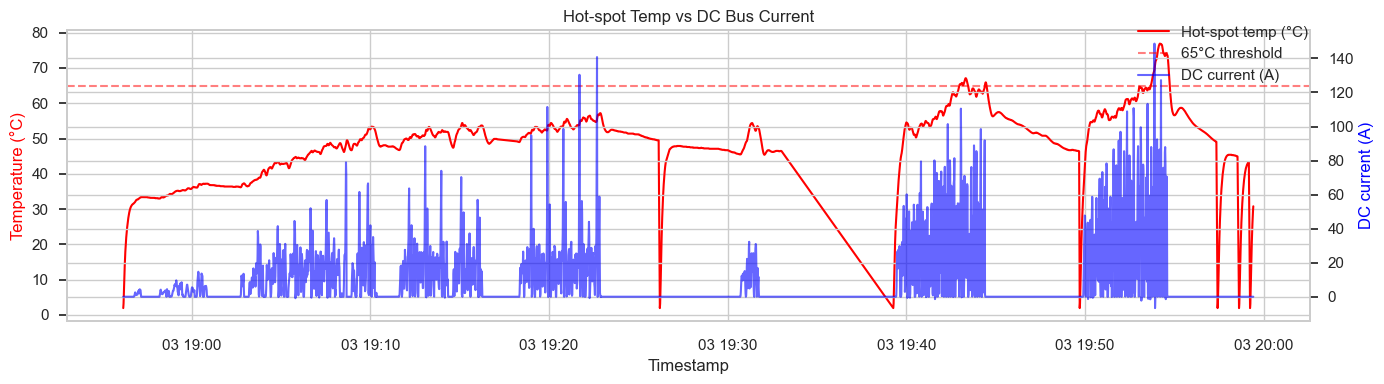

In [19]:
fig, ax1 = plt.subplots(figsize=(14, 4))
ax1.plot(df['timestamp'], df['inv_hot_spot_temp_mean'], color='red', label='Hot-spot temp (°C)')
ax1.axhline(65, color='red', linestyle='--', alpha=0.5, label='65°C threshold')
ax1.set_ylabel('Temperature (°C)', color='red')
ax2 = ax1.twinx()
ax2.plot(df['timestamp'], df['inv_dc_bus_current_mean'], color='blue', alpha=0.6, label='DC current (A)')
ax2.set_ylabel('DC current (A)', color='blue')
ax1.set_xlabel('Timestamp')
ax1.set_title('Hot-spot Temp vs DC Bus Current')
fig.legend(loc='upper right', bbox_to_anchor=(0.95, 0.95))
plt.tight_layout()

## 11. Distribution Plots

Histogram/KDE views for key signals to understand their spread and highlight differences across labels.

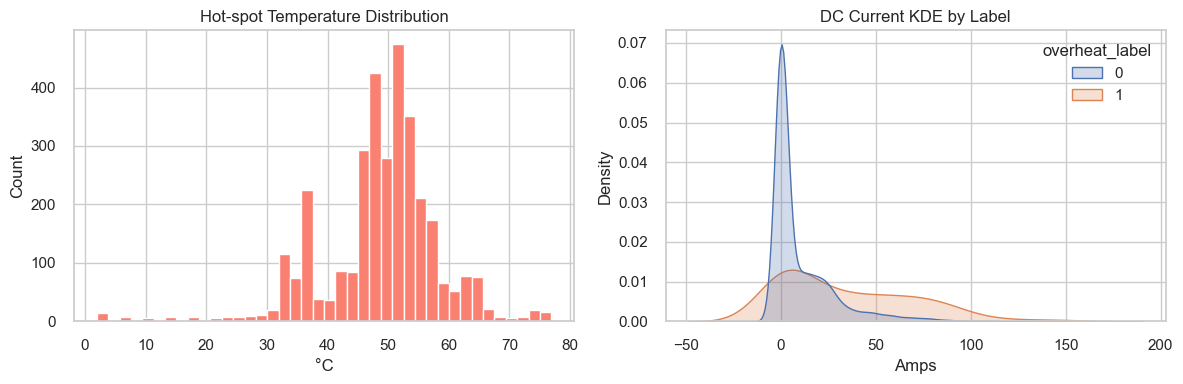

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].hist(df['inv_hot_spot_temp_mean'], bins=40, color='salmon')
axes[0].set_title('Hot-spot Temperature Distribution')
axes[0].set_xlabel('°C')
axes[0].set_ylabel('Count')

if 'overheat_label' not in df.columns:
    df['overheat_label'] = (df['inv_hot_spot_temp_mean'] >= 65).astype(int)

df_nonnull = df.dropna(subset=['inv_dc_bus_current_mean'])
sns.kdeplot(data=df_nonnull, x='inv_dc_bus_current_mean', hue='overheat_label', fill=True, common_norm=False, ax=axes[1])
axes[1].set_title('DC Current KDE by Label')
axes[1].set_xlabel('Amps')
plt.tight_layout()


## 12. Rolling Trends Around Overheating

Compute rolling means and gradients to inspect how temperatures evolve prior to overheating events.

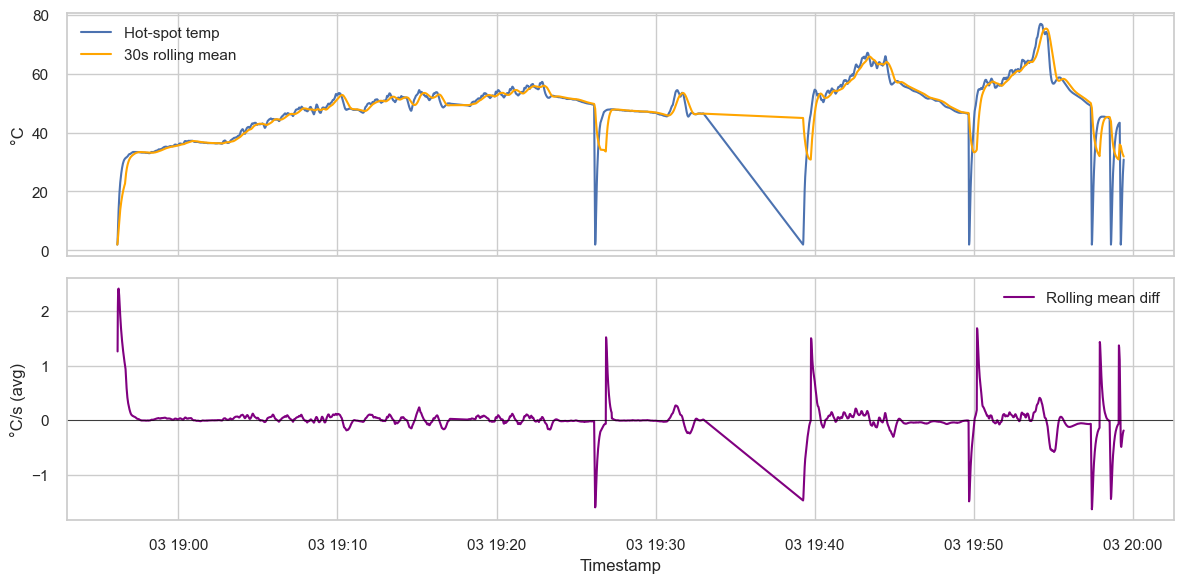

In [21]:
roll_window = 30  # seconds
df['hotspot_roll_mean'] = df['inv_hot_spot_temp_mean'].rolling(roll_window, min_periods=1).mean()
df['hotspot_roll_grad'] = df['inv_hot_spot_temp_mean'].diff().rolling(roll_window, min_periods=1).mean()

fig, axes = plt.subplots(2, 1, figsize=(12,6), sharex=True)
axes[0].plot(df['timestamp'], df['inv_hot_spot_temp_mean'], label='Hot-spot temp')
axes[0].plot(df['timestamp'], df['hotspot_roll_mean'], label=f"{roll_window}s rolling mean", color='orange')
axes[0].set_ylabel('°C')
axes[0].legend()

axes[1].plot(df['timestamp'], df['hotspot_roll_grad'], color='purple', label='Rolling mean diff')
axes[1].axhline(0, color='black', linewidth=0.5)
axes[1].set_ylabel('°C/s (avg)')
axes[1].set_xlabel('Timestamp')
axes[1].legend()
plt.tight_layout()


## 13. Hot-Spot Event Zoom

Visualize a representative overheating event (if available) with preceding currents and temperatures.

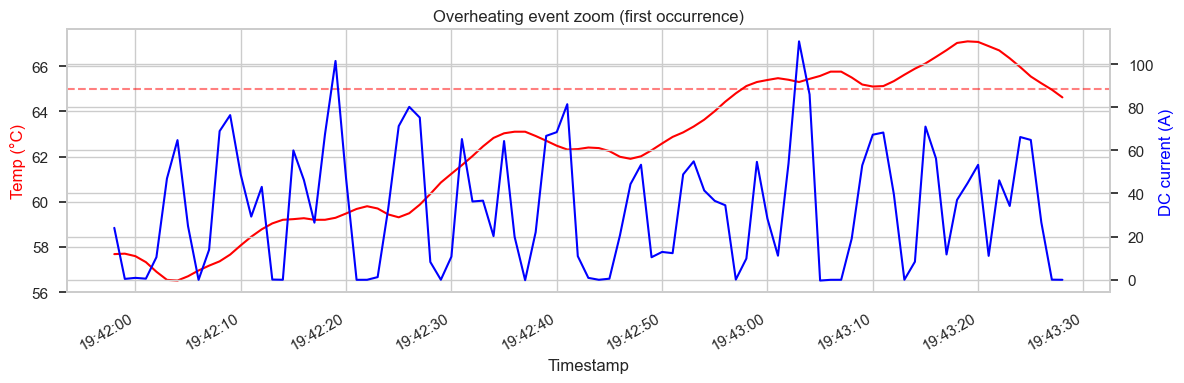

In [22]:
event_indices = df.index[df['overheat_label'] == 1]
if len(event_indices) == 0:
    print('No overheating events in this dataset.')
else:
    idx = event_indices[0]
    start = max(0, idx - 60)
    end = min(len(df) - 1, idx + 30)
    window = df.iloc[start:end+1]
    fig, ax1 = plt.subplots(figsize=(12,4))
    ax1.plot(window['timestamp'], window['inv_hot_spot_temp_mean'], color='red', label='Hot-spot temp')
    ax1.axhline(65, color='red', linestyle='--', alpha=0.5)
    ax1.set_ylabel('Temp (°C)', color='red')
    ax2 = ax1.twinx()
    ax2.plot(window['timestamp'], window['inv_dc_bus_current_mean'], color='blue', label='DC current')
    ax2.set_ylabel('DC current (A)', color='blue')
    ax1.set_title('Overheating event zoom (first occurrence)')
    ax1.set_xlabel('Timestamp')
    fig.autofmt_xdate()
    fig.tight_layout()


## 14. Idle vs Load Temperature Comparison

Compare hot-spot temperature distributions between idle and load periods (|DC current| ≤ 0.1 A).

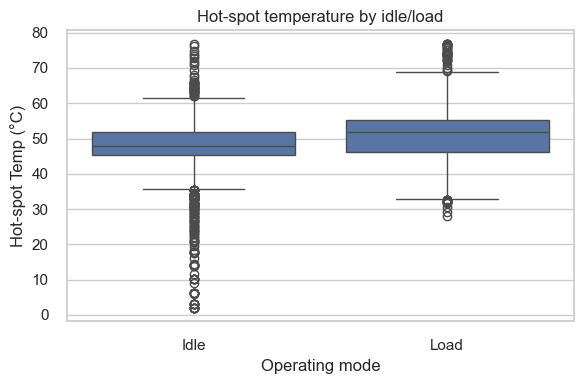

In [23]:
idle_thresh = 0.1
mode = df['inv_dc_bus_current_mean'].abs() <= idle_thresh
fig, ax = plt.subplots(figsize=(6,4))
sns.boxplot(x=mode.map({True: 'Idle', False: 'Load'}), y=df['inv_hot_spot_temp_mean'], ax=ax)
ax.set_ylabel('Hot-spot Temp (°C)')
ax.set_xlabel('Operating mode')
ax.set_title('Hot-spot temperature by idle/load')
plt.tight_layout()
